In [1]:
# Install necessary packages
%pip install idx2numpy
%pip install tensorflow  # or keras, depending on your framework
%pip install torch torchvision torchaudio  # for PyTorch
%pip install ipykernel  # Install ipykernel for Jupyter
%pip install effdet

  Preparing metadata (setup.py) ... done
  Created wheel for idx2numpy: filename=idx2numpy-1.2.3-py3-none-any.whl size=7904 sha256=dec37bcd80d8f4b8949024e514c78e88208ef60e0821704e55a3d734f9caa511
  Stored in directory: /root/.cache/pip/wheels/e0/f4/e7/643fc5f932ec2ff92997f43f007660feb23f948aa8486f1107
Successfully built idx2numpy
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.5/112.5 kB 5.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import idx2numpy
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import ViTModel, ViTConfig

# Load training data
train_images = idx2numpy.convert_from_file('/kaggle/input/mnist-dataset/train-images.idx3-ubyte')
train_labels = idx2numpy.convert_from_file('/kaggle/input/mnist-dataset/train-labels.idx1-ubyte')

# Load test data
test_images = idx2numpy.convert_from_file('/kaggle/input/mnist-dataset/t10k-images.idx3-ubyte')
test_labels = idx2numpy.convert_from_file('/kaggle/input/mnist-dataset/t10k-labels.idx1-ubyte')

# Check the shape of the loaded data
print(f'Train images shape: {train_images.shape}')
print(f'Train labels shape: {train_labels.shape}')
print(f'Test images shape: {test_images.shape}')
print(f'Test labels shape: {test_labels.shape}')

Train images shape: (60000, 28, 28)
Train labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)


In [3]:
# Normalize the images to the range [0, 1]
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# Reshape the images to add a channel dimension (for CNNs)
train_images = train_images.reshape(-1, 28, 28, 1)
test_images = test_images.reshape(-1, 28, 28, 1)

# Convert to PyTorch tensors
train_images_tensor = torch.tensor(train_images, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
test_images_tensor = torch.tensor(test_images, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

# Create TensorDatasets
train_dataset = TensorDataset(train_images_tensor, train_labels_tensor)
test_dataset = TensorDataset(test_images_tensor, test_labels_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [4]:
# ViT for MNIST (PyTorch)

import torch
import torch.nn as nn
from torch.amp import autocast, GradScaler
from transformers import ViTConfig, ViTModel

# Check if GPU is available and set the device accordingly

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define hyperparameters
batch_size = 64  # Increased from 32 to better utilize GPUs
learning_rate = 3e-4  # Standard learning rate for transformers
weight_decay = 0.01  # Add weight decay for better regularization

# Configure ViT model with optimized parameters
config = ViTConfig(
    image_size=28,
    patch_size=7,
    num_classes=10,
    hidden_size=256,  # Increased for better feature representation
    num_hidden_layers=6,  # Increased number of layers
    num_attention_heads=8,  # Increased number of attention heads
    num_channels=1  # Set to 1 for grayscale images
)

# Initialize model
model = ViTModel(config)

# Wrap model with DataParallel if multiple GPUs are available
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model)

# Move model to GPU
model = model.to(device)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Initialize optimizer with weight decay
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=learning_rate,
    weight_decay=weight_decay,
    betas=(0.9, 0.999),
    eps=1e-8
)

# Initialize gradient scaler for mixed precision training
scaler = GradScaler('cuda')

# Create data loader with suggested number of workers
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size * torch.cuda.device_count(),  # Scale batch size by number of GPUs
    shuffle=True,
    num_workers=4,  # Reduced to suggested maximum
    pin_memory=True
)



Using 2 GPUs!


In [5]:
import torch
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from tqdm import tqdm
import numpy as np

# Training hyperparameters
num_epochs = 30  # Increased epochs for better convergence
warmup_epochs = 2
min_lr = 1e-6
patience = 3  # For early stopping

# Initialize learning rate scheduler
scheduler = CosineAnnealingWarmRestarts(
    optimizer,
    T_0=num_epochs // 3,  # Restart every 1/3 of total epochs
    T_mult=2,  # Multiply period by 2 after each restart
    eta_min=min_lr
)

# Initialize early stopping parameters
best_loss = float('inf')
patience_counter = 0
best_model_state = None

# Training loop with progress bar
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    # Use tqdm for progress tracking
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}')
    
    for images, labels in progress_bar:
        # Warmup learning rate for initial epochs
        if epoch < warmup_epochs:
            lr_scale = min(1., float(epoch * len(train_loader) + progress_bar.n + 1) / (warmup_epochs * len(train_loader)))
            for pg in optimizer.param_groups:
                pg['lr'] = lr_scale * learning_rate

        # Move data to device
        labels = labels.to(device)
        images = images.to(device)
        
        # Ensure the shape is correct
        images = images.permute(0, 3, 1, 2)
        
        # Zero the parameter gradients
        optimizer.zero_grad(set_to_none=True)  # More efficient than zero_grad()
        
        # Forward pass with mixed precision
        with autocast():
            outputs = model(images)
            logits = outputs.last_hidden_state[:, 0]
            loss = criterion(logits, labels)
            
            # Calculate accuracy for this batch
            _, predicted = torch.max(logits.data, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
        
        # Backward pass and optimization with gradient scaling
        scaler.scale(loss).backward()
        
        # Gradient clipping
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += loss.item()
        
        # Update progress bar
        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100.0 * correct_predictions / total_predictions:.2f}%'
        })
    
    # Calculate epoch metrics
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100.0 * correct_predictions / total_predictions
    
    # Update learning rate
    if epoch >= warmup_epochs:
        scheduler.step()
    
    # Print epoch results
    print(f'\nEpoch [{epoch + 1}/{num_epochs}]')
    print(f'Loss: {epoch_loss:.4f}')
    print(f'Accuracy: {epoch_accuracy:.2f}%')
    print(f'Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')
    
    # Early stopping check
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        best_model_state = model.state_dict().copy()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'Early stopping triggered after epoch {epoch + 1}')
            model.load_state_dict(best_model_state)
            break

# Save the best model
torch.save(best_model_state, 'best_model.pth')


Epoch 1/30:   0%|          | 0/469 [00:00<?, ?it/s]<ipython-input-5-8ed885436fae>:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/30: 100%|██████████| 469/469 [00:22<00:00, 21.17it/s, loss=0.3798, acc=74.91%]



Epoch [1/30]
Loss: 0.9331
Accuracy: 74.91%
Learning Rate: 0.000150


Epoch 2/30: 100%|██████████| 469/469 [00:21<00:00, 22.14it/s, loss=0.4539, acc=93.16%]



Epoch [2/30]
Loss: 0.2264
Accuracy: 93.16%
Learning Rate: 0.000300


Epoch 3/30: 100%|██████████| 469/469 [00:20<00:00, 22.54it/s, loss=0.1122, acc=95.54%]



Epoch [3/30]
Loss: 0.1456
Accuracy: 95.54%
Learning Rate: 0.000293


Epoch 4/30: 100%|██████████| 469/469 [00:20<00:00, 22.66it/s, loss=0.0461, acc=96.93%]



Epoch [4/30]
Loss: 0.1031
Accuracy: 96.93%
Learning Rate: 0.000271


Epoch 5/30: 100%|██████████| 469/469 [00:21<00:00, 22.09it/s, loss=0.0382, acc=97.56%]



Epoch [5/30]
Loss: 0.0776
Accuracy: 97.56%
Learning Rate: 0.000238


Epoch 6/30: 100%|██████████| 469/469 [00:20<00:00, 22.57it/s, loss=0.0587, acc=98.07%]



Epoch [6/30]
Loss: 0.0623
Accuracy: 98.07%
Learning Rate: 0.000197


Epoch 7/30: 100%|██████████| 469/469 [00:21<00:00, 22.32it/s, loss=0.1564, acc=98.62%]



Epoch [7/30]
Loss: 0.0430
Accuracy: 98.62%
Learning Rate: 0.000150


Epoch 8/30: 100%|██████████| 469/469 [00:20<00:00, 22.54it/s, loss=0.0042, acc=99.09%]



Epoch [8/30]
Loss: 0.0289
Accuracy: 99.09%
Learning Rate: 0.000104


Epoch 9/30: 100%|██████████| 469/469 [00:21<00:00, 22.23it/s, loss=0.0307, acc=99.50%]



Epoch [9/30]
Loss: 0.0162
Accuracy: 99.50%
Learning Rate: 0.000063


Epoch 10/30: 100%|██████████| 469/469 [00:20<00:00, 22.39it/s, loss=0.0014, acc=99.80%]



Epoch [10/30]
Loss: 0.0072
Accuracy: 99.80%
Learning Rate: 0.000030


Epoch 11/30: 100%|██████████| 469/469 [00:20<00:00, 22.54it/s, loss=0.0057, acc=99.95%]



Epoch [11/30]
Loss: 0.0026
Accuracy: 99.95%
Learning Rate: 0.000008


Epoch 12/30: 100%|██████████| 469/469 [00:20<00:00, 22.46it/s, loss=0.0002, acc=99.99%]



Epoch [12/30]
Loss: 0.0014
Accuracy: 99.99%
Learning Rate: 0.000300


Epoch 13/30: 100%|██████████| 469/469 [00:20<00:00, 22.34it/s, loss=0.0348, acc=97.61%]



Epoch [13/30]
Loss: 0.0779
Accuracy: 97.61%
Learning Rate: 0.000298


Epoch 14/30: 100%|██████████| 469/469 [00:20<00:00, 22.57it/s, loss=0.0282, acc=98.10%]



Epoch [14/30]
Loss: 0.0602
Accuracy: 98.10%
Learning Rate: 0.000293


Epoch 15/30: 100%|██████████| 469/469 [00:21<00:00, 22.10it/s, loss=0.0760, acc=98.58%]



Epoch [15/30]
Loss: 0.0451
Accuracy: 98.58%
Learning Rate: 0.000284
Early stopping triggered after epoch 15


In [6]:
# Testing loop
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Ensure the shape is (batch_size, num_channels, height, width)
        images = images.permute(0, 3, 1, 2)  # Change from (batch_size, height, width, num_channels) to (batch_size, num_channels, height, width)
        
        # Forward pass
        outputs = model(images)  # Get the model output
        logits = outputs.last_hidden_state[:, 0]  # Use the first token's hidden state for classification
        _, predicted = torch.max(logits.data, 1)  # Get the predicted class
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Accuracy: {100 * correct / total:.2f}%')

Test Accuracy: 97.92%


In [7]:
torch.save(model.state_dict(), 'efficientdet_model.pth')

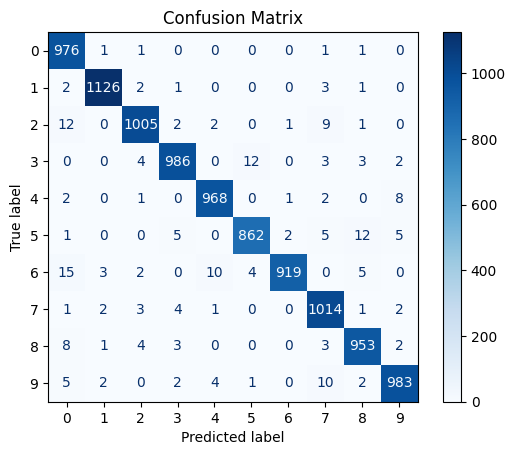

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming you have the true labels and predicted labels
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Ensure the shape is (batch_size, num_channels, height, width)
        images = images.permute(0, 3, 1, 2)  # Change from (batch_size, height, width, num_channels) to (batch_size, num_channels, height, width)
        
        outputs = model(images)  # Get the model output
        logits = outputs.last_hidden_state[:, 0]  # Use the first token's hidden state for classification
        _, predicted = torch.max(logits.data, 1)  # Get the predicted class
        
        y_true.extend(labels.cpu().numpy())  # Collect true labels
        y_pred.extend(predicted.cpu().numpy())  # Collect predicted labels

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

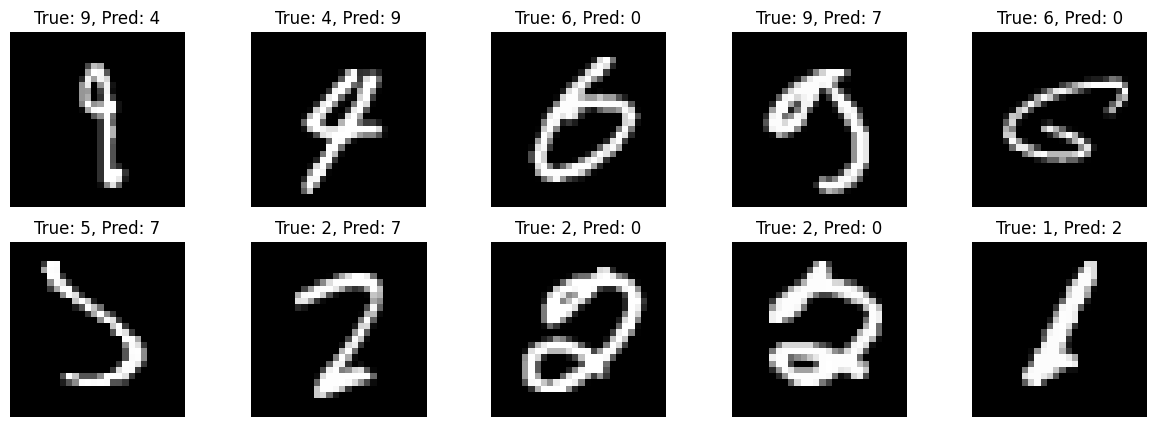

In [9]:
import matplotlib.pyplot as plt

def visualize_misclassifications(images, true_labels, predicted_labels, num_images=10):
    misclassified_indices = [i for i in range(len(true_labels)) if true_labels[i] != predicted_labels[i]]
    selected_indices = np.random.choice(misclassified_indices, num_images, replace=False)

    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(selected_indices):
        plt.subplot(2, num_images//2, i + 1)
        plt.imshow(images[idx].squeeze(), cmap='gray')
        plt.title(f'True: {true_labels[idx]}, Pred: {predicted_labels[idx]}')
        plt.axis('off')
    plt.show()

# Call the function with your test images and labels
visualize_misclassifications(test_images_tensor.cpu().numpy(), y_true, y_pred)